# NBA Wins Predictions

## Imports

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
np.random.seed(102) # picking a random seed for model simulations
pd.options.mode.chained_assignment = None 

## Does More 3s Lead to More Points?

We will be using an unconfoundedness method, specifically outcome regression, to see if we can find a causal impact between shooting more 3s and scoring more points. 

As for why outcome regression, we wanted to use an unconfoundedness method since we didn’t have a source of randomness to produce a natural experiment, and since we are accounting for a lot of confounders, we felt like creating a regression model that takes into account observable confounders that have a linear relationship made the most sense.

We are faced with some limitations, as we cannot observe every single possible confounder (like the team strategy dilemma mentioned in our data overview). So, our utilization of the unconfoundedness assumption, while still likely valid, does operate under a level of uncertainty. If it turns out that these unobserved confounders have a lot of influence over our causal impact estimate, then we are left with a result that is unusable. 

### Loading and Cleaning Data

In [105]:
players = pd.read_csv('./data/2023_players.csv')
players.head(5)

,RANK,NAME,TEAM,POS,AGE,GP,MPG,USG%,TO%,FTA,...,APG,SPG,BPG,TPG,P+R,P+A,P+R+A,VI,ORtg,DRtg
0,NaN,Joel Embiid,Phi,C-F,29.1,66,34.6,37.0,14.5,771,...,4.2,1.0,1.7,3.4,43.2,37.2,47.4,13.0,124.4,104.1
1,NaN,Luka Doncic,Dal,F-G,24.1,66,36.2,37.7,14.0,694,...,8.0,1.4,0.5,3.6,41.0,40.4,49.0,14.4,120.0,109.2
2,NaN,Damian Lillard,Por,G,32.7,58,36.3,33.8,13.7,558,...,7.3,0.9,0.3,3.3,36.9,39.5,44.3,11.5,126.4,117.6
3,NaN,Shai Gilgeous-Alexander,Okc,G-F,24.7,68,35.5,32.8,12.2,739,...,5.5,1.6,1.0,2.8,36.2,36.9,41.7,10.6,124.9,109.8
4,NaN,Giannis Antetokounmpo,Mil,F,28.3,63,32.1,38.8,16.2,772,...,5.7,0.8,0.8,3.9,42.9,36.8,48.6,15.9,116.8,100.6


Legend: 
    
RANK: Player Rank based off overall statistical performance. </br></br>
NAME: Name of the player. </br></br>
TEAM: The NBA team the player plays for. </br></br>
POS: Position of the player. </br></br>
AGE: Age of the player in years. </br></br>
GP: Games Played. </br></br>
MPG: Minutes per game. </br></br>
USG%: Usage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor. </br></br>
TO%: A metric that estimates the number of turnovers a player commits per 100 possessions </br></br>
FTA: number of free throws Attempted. </br></br>
FT%: Percentage of free throws made. </br></br>
2PA: Number of 2 point shots attempted. </br></br>
2P%: 2 point shot percentage. </br></br>
3PA: Number of 3 point shots attempted. </br></br>
3P%: Percentage of 3 point shots. </br></br>
eFG%: With eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA </br></br>
TS%: True shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws </br></br>
PPG: Number of Points per game. </br></br>
RPG: Number of Rebounds per game. </br></br>
APG: Number of Assists per game. </br></br>
SPG: Number of Steals per game. </br></br>
BPG: Number of Blocks per game. </br></br>
TPG: Number of Turnovers per game.  </br></br>
P+R: Number of Points and Rebounds per game. </br></br>
P+A: Number of Points and Assists per game. </br></br>
P+R+A: Number of Points, Rebounds, and Assists per game. </br></br>
VI: The versatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10. </br></br>
ORtg: Individual offensive rating is the number of points produced by a player per 100 total individual possessions. </br></br>
DRtg: Individual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court. </br></br>

We add the rank in manually, as on the NBAstuffer.com site, the players are ordered by rank (descending). 

In [106]:
players['RANK'] = range(1, len(players['RANK']) + 1)
players.head(5)

,RANK,NAME,TEAM,POS,AGE,GP,MPG,USG%,TO%,FTA,...,APG,SPG,BPG,TPG,P+R,P+A,P+R+A,VI,ORtg,DRtg
0,1,Joel Embiid,Phi,C-F,29.1,66,34.6,37.0,14.5,771,...,4.2,1.0,1.7,3.4,43.2,37.2,47.4,13.0,124.4,104.1
1,2,Luka Doncic,Dal,F-G,24.1,66,36.2,37.7,14.0,694,...,8.0,1.4,0.5,3.6,41.0,40.4,49.0,14.4,120.0,109.2
2,3,Damian Lillard,Por,G,32.7,58,36.3,33.8,13.7,558,...,7.3,0.9,0.3,3.3,36.9,39.5,44.3,11.5,126.4,117.6
3,4,Shai Gilgeous-Alexander,Okc,G-F,24.7,68,35.5,32.8,12.2,739,...,5.5,1.6,1.0,2.8,36.2,36.9,41.7,10.6,124.9,109.8
4,5,Giannis Antetokounmpo,Mil,F,28.3,63,32.1,38.8,16.2,772,...,5.7,0.8,0.8,3.9,42.9,36.8,48.6,15.9,116.8,100.6


For our analysis, we don't need the player name or team, since these are categorical variables that will not help us in any way.

In [107]:
players.drop(columns = ['NAME', 'TEAM'], inplace = True)

We also drop the P+R, P+A, P+R+A columns since those are linear combinations of existing columns PPG, APG, and RPG, and therefore give us no additional information.

In [108]:
players.drop(columns = ['P+R', 'P+A', 'P+R+A'], inplace = True)

Since our Player Dataset includes all players in the NBA, even those who might have not played a single minute, there will be some very low statistics in our dataset. Therefore, I made some cutoffs for individual players. I decided to include players who played at least 12 minutes per game, which corresponds to one quarter of a full 48 minute game, and players who played at least 21 games in the season, which is the rounded up quarter of a full 82 game season. There is not much research out there for an ideal cutoff; FiveThirtyEight uses the 1000 minute mark for their RAPTOR metric, which corresponds to roughly 12 minutes per game if a player plays a full 82 game regular season. So, I took this 12 minute threshold from them, but introduced a lower game threshold so I could include more players in our dataset. There was also a basketball intuition to the games cutoff, where a player who plays at least a quarter of a season is less likely to be susceptible to random variation like a “hot-streak” for shooting. 

In [109]:
# create the minutes played and games played threshold

eligible = players[(players['GP'] >= 21) & (players['MPG'] >= 12)]

In [110]:
# creating a per-game column for 3PA by dividing by games played (GP)

eligible.rename(columns = {'3PA': '3PA_total'}, inplace = True)
eligible['3PA'] = np.round(eligible['3PA_total'].values / eligible['GP'].values, 1)
eligible.drop(columns = ['3PA_total'], inplace = True)

#### Is There a Linear Relationship Between 3s Attempted and Points Scored?

Next, we look to see if 3 point attempts is generally correlated with points scored; if it is, we have a starting point for performing our analysis.

Text(0.5, 1.0, '3PA vs. PPG')

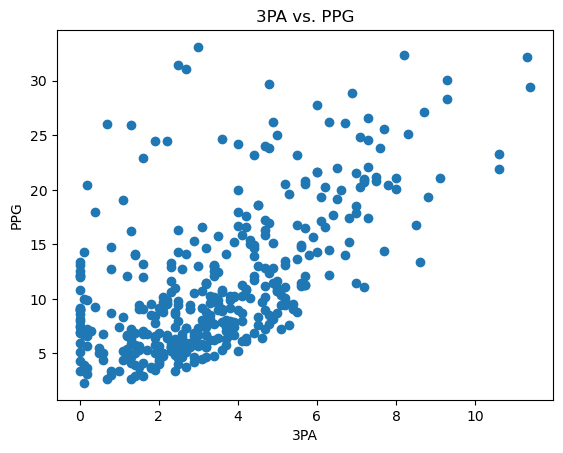

In [111]:
plt.scatter(eligible['3PA'], eligible['PPG'])
plt.xlabel('3PA')
plt.ylabel('PPG')
plt.title('3PA vs. PPG')

In [112]:
eligible[['3PA', 'PPG']].corr()

,3PA,PPG
3PA,1.000000,0.615261
PPG,0.615261,1.000000


As we can see above, our 3PA and PPG have a positive linear correlation, which tells us there is a level of linear association that would expect someone with more three point attempts to on average score more points. This is not particularly surprising, as shooting shots that have more value if converted would intuitively mean a player is going to score more points. This tells us that exploring the causal impact of 3PA on PPG has merit.

### Methodology: Nonlinear Outcome Regression

We will be using an unconfoundedness method, specifically outcome regression, to see if we can find a causal impact. 

As for why outcome regression, we wanted to use an unconfoundedness method since we didn’t have a source of randomness to produce a natural experiment, and since we are accounting for a lot of confounders, we felt like creating a regression model that takes into account observable confounders that have a linear relationship made the most sense.

We are faced with some limitations, as we cannot observe every single possible confounder (like the team strategy dilemma mentioned in our data overview). So, our utilization of the unconfoundedness assumption, while still likely valid, does operate under a level of uncertainty. If it turns out that these unobserved confounders have a lot of influence over our causal impact estimate, then we are left with a result that is unusable. 

#### Testing Potential Confounders/Covariates

A confounder is a variable that has causal impact on our treatment and outcome variables, a collider is a variable that is caused by our treatment and outcome variable. We want to include confounders in our regression to accurately capture causal impact of 3PA, but we want to exclude colliders because they have no causal information.

For determining potential confounders, we will use the cutoff of 0.2 correlation; that is, if a variable has at least 0.10 correlation with both treatment and outcome, it will be considered a confounder. This is an arbitrary cutoff, but considering the lack of research behind what constitutes a "good" cutoff, we will stick with this. 

As for potential colliders, a DAG cultivated using basketball background knowledge will be included at the bottom of the page. There is not much research on colliders in basketball, so naturally my rationale is going to be subjective. I will include justifications along with the DAG.

#### Confounders

Our only categorical variable remaining is position, so we have to binarize using dummy/indicator variables.

There are 3 position groupings in basketball: guard (G), forward (F), and center (C). Additionally, some players are listed as being more than one position:

In [113]:
eligible['POS'].value_counts()

G      155
F      113
G-F     37
F-C     30
C       30
F-G     17
C-F     15
Name: POS, dtype: int64

In order to account for those who play multiple positions, we will make each of those combinations their own position group. This will ensure each player only has a single 1 for any of our dummy variables, and is also likely to be more reflective of the fact that someone who can play different positions likely deserves a different categorization.

In [114]:
dummy_pos = pd.get_dummies(eligible['POS'])
eligible.drop(columns = ['POS'], inplace = True)
eligible = pd.concat([eligible, dummy_pos], axis = 1)

We will now look at the correlation matrix with our position indicators, excluding any that do not meet our threshold:

In [115]:
pos_corr = eligible[['3PA', 'PPG', 'G', 'F', 'G-F', 'F-C', 'C', 'F-G', 'C-F']].corr()
pos_conf = list(set(pos_corr[(pos_corr['3PA'].abs() > 0.2) & (pos_corr['PPG'].abs() > 0.2)].index) - set(['3PA', 'PPG']))
pos_conf

[]

None of our position indicators have a strong relationship with both PPG and 3PA, so we will not be using position as a potential confounder. 

As for further research, some more insight on the amount of time a player spends at a given position would be helpful. We could therefore create a new category where we weight the time someone spends at a position, as it would be more telling than a binary variable for the position.

Let's observe the correlations between the remaining potential confounders: 

In [117]:
positions = ['G', 'F', 'G-F', 'F-C', 'C', 'F-G', 'C-F']
remaining_confounders = eligible[eligible.columns.difference(positions)]
remaining_corr = remaining_confounders.corr()
remaining_conf = list(set(remaining_corr[(remaining_corr['3PA'].abs() > 0.2) & (
    remaining_corr['PPG'].abs() > 0.2)].index) - set(['3PA', 'PPG']))
remaining_conf

['2PA', 'FTA', 'MPG', 'RANK', 'SPG', 'FT%', 'BPG', 'APG', 'USG%', 'TPG']

So, we are left with the above possible confounders. I will plot the scatterplots to show the strength of the linear associations below:

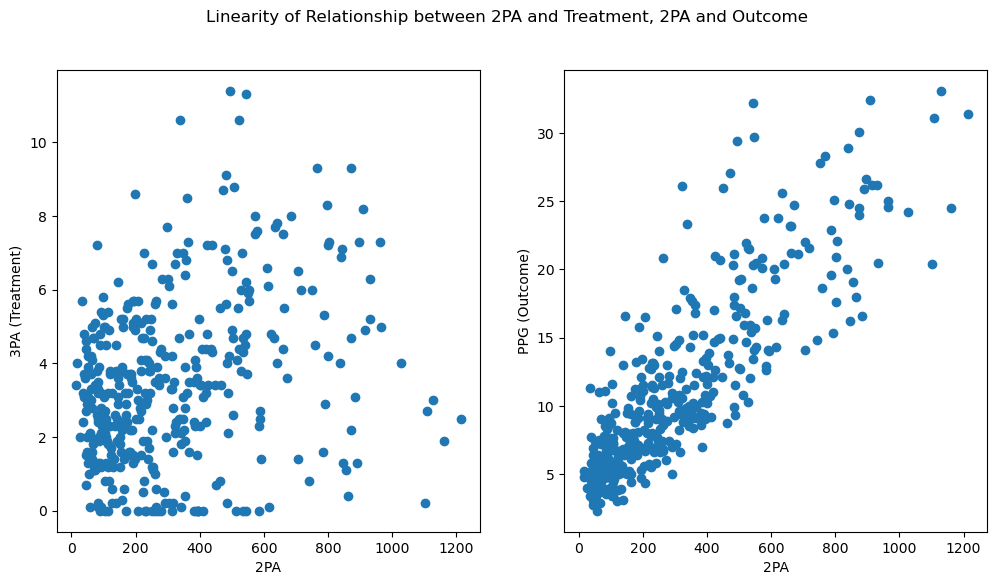

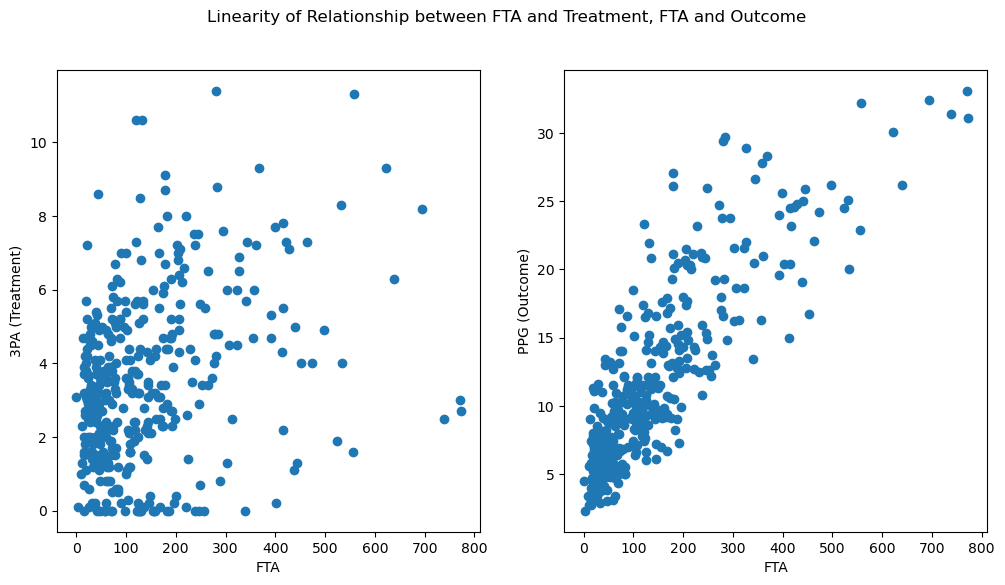

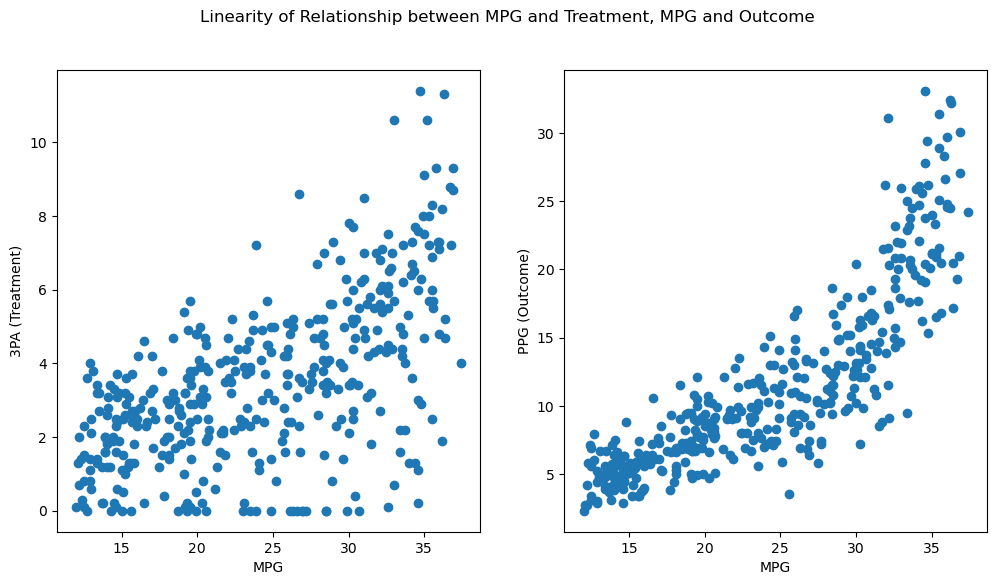

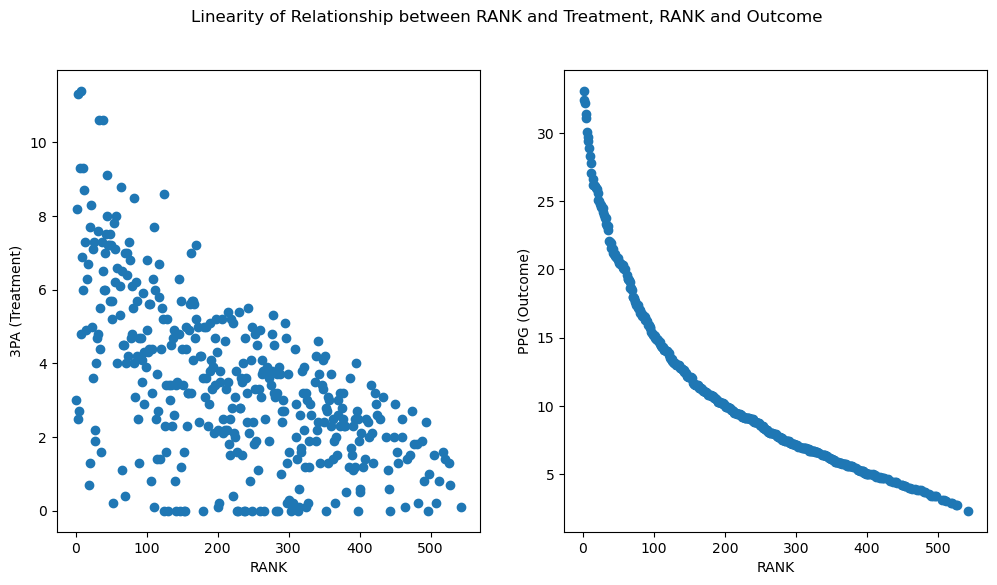

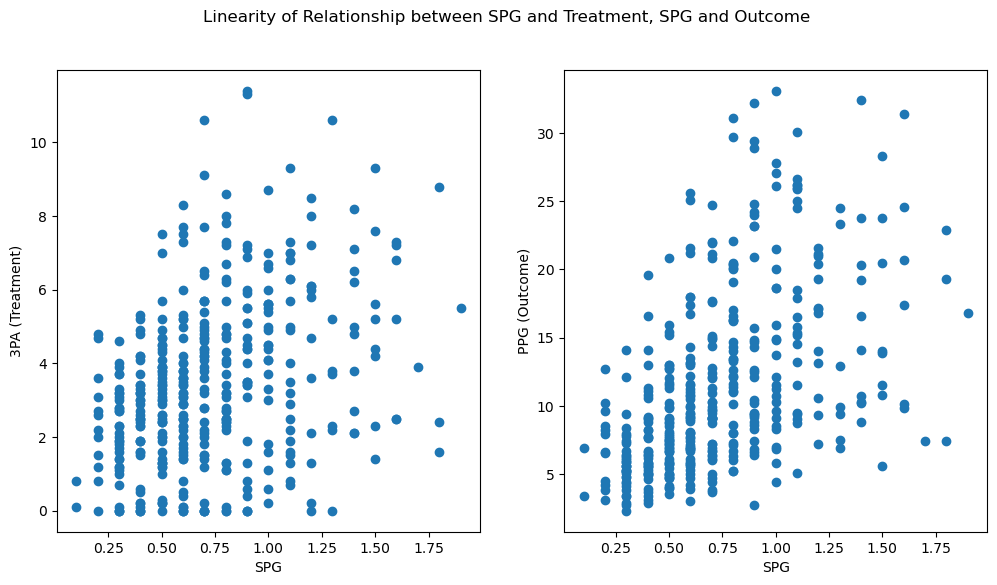

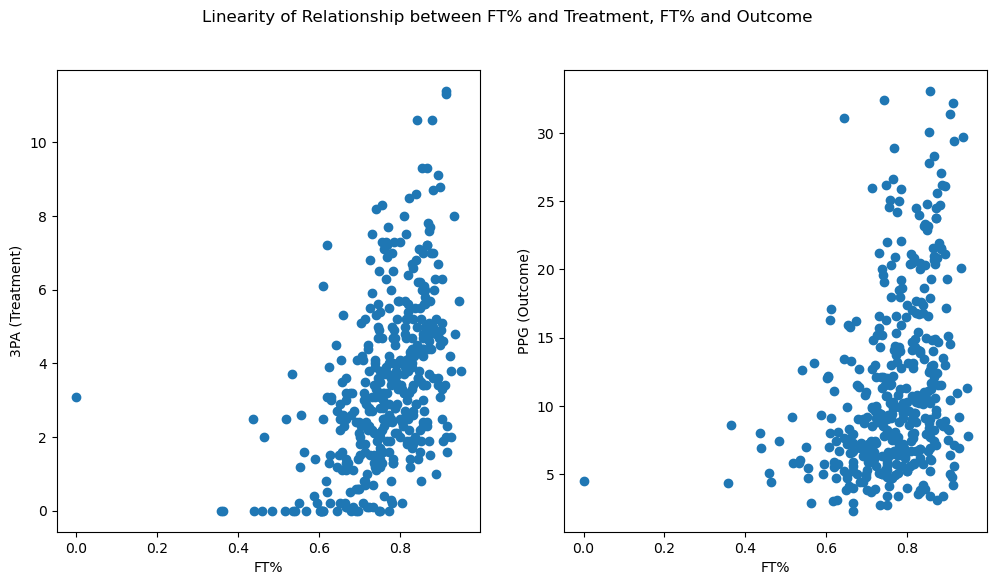

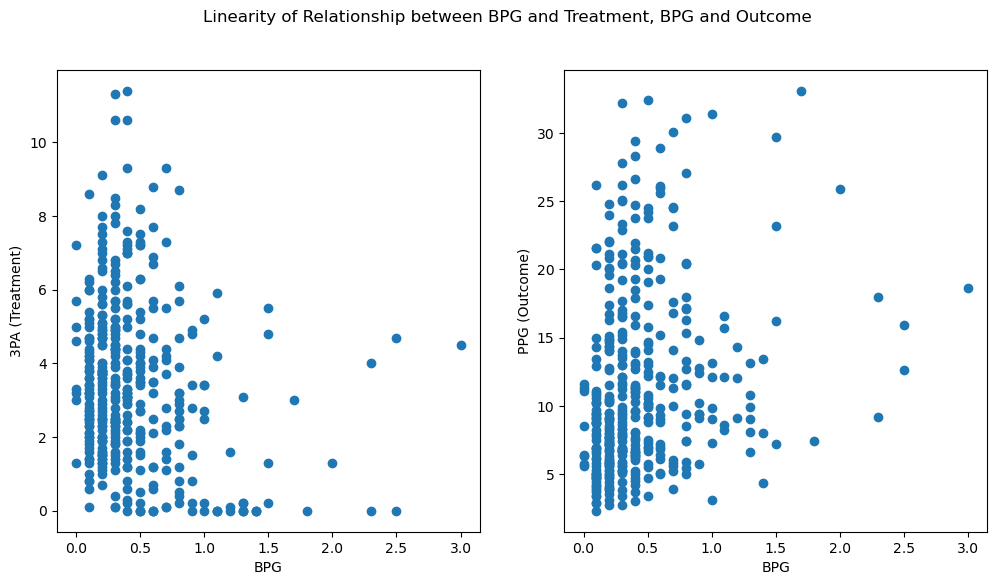

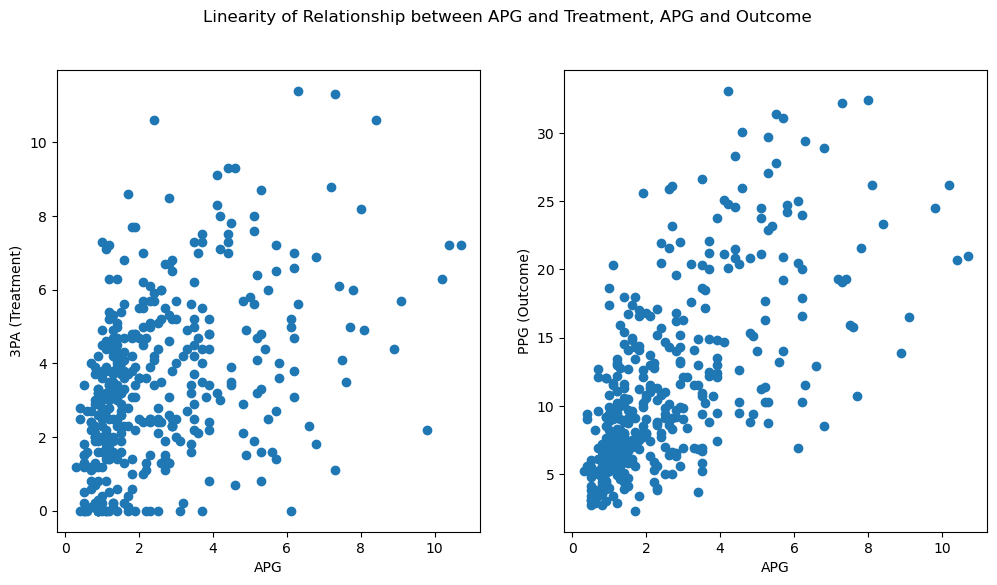

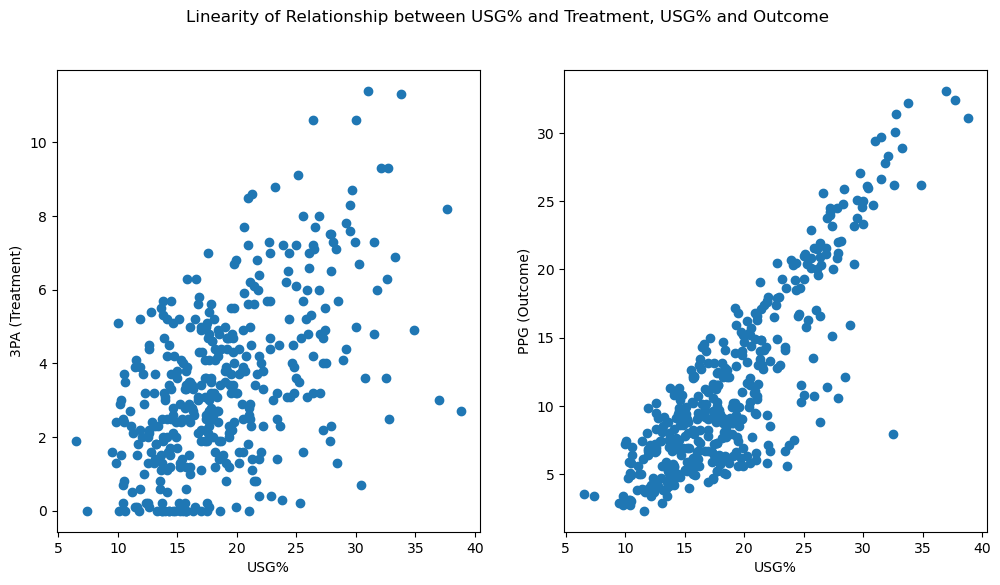

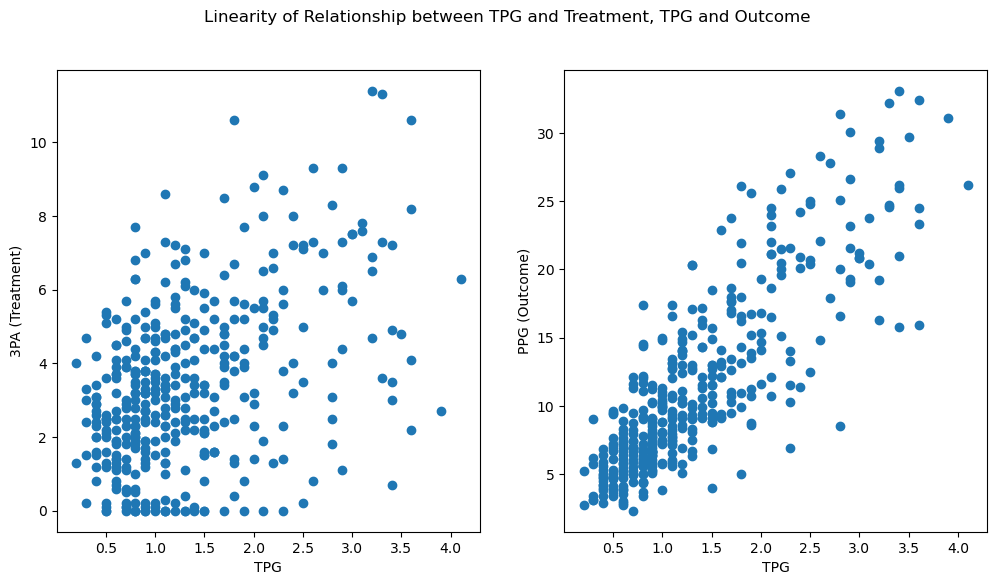

In [118]:
def plot_treatment_outcome_confounder(confounder):
    fig, sbp = plt.subplots(ncols=2, figsize=(12, 6))
    ax0 = sbp[0] 
    ax1 = sbp[1]
    fig.suptitle(f'Linearity of Relationship between {confounder} and Treatment, {confounder} and Outcome')
    
    # plotting the treatment and confounder correlation 
    ax0.set_xlabel(confounder)
    ax0.set_ylabel('3PA (Treatment)')
    s = ax0.scatter(eligible[confounder], eligible['3PA'])
    
    # plotting the outcome and confounder correlation
    ax1.set_xlabel(confounder)
    ax1.set_ylabel('PPG (Outcome)')
    s = ax1.scatter(eligible[confounder], eligible['PPG'])
    

confounders = [item for item in remaining_conf]

for confounder in confounders:
    plot_treatment_outcome_confounder(confounder)

I will also plot the correlation matrix below to see if we can identify any confounders that have strong correlation with each other; if we do find any, we may have to drop them to alleviate multicollinearity concerns.

In [119]:
eligible[['3PA', 'PPG'] + remaining_conf].corr()

,3PA,PPG,2PA,FTA,MPG,RANK,SPG,FT%,BPG,APG,USG%,TPG
3PA,1.000000,0.615261,0.290226,0.324065,0.589669,-0.597201,0.346679,0.470281,-0.208728,0.434180,0.538733,0.439687
PPG,0.615261,1.000000,0.846369,0.843642,0.848328,-0.911432,0.504187,0.329297,0.217906,0.651975,0.852027,0.834865
2PA,0.290226,0.846369,1.000000,0.885363,0.749401,-0.783426,0.448596,0.169360,0.313362,0.558024,0.711462,0.755989
FTA,0.324065,0.843642,0.885363,1.000000,0.680907,-0.721212,0.388991,0.188067,0.278296,0.528151,0.715525,0.739082
MPG,0.589669,0.848328,0.749401,0.680907,1.000000,-0.883498,0.653937,0.270413,0.260737,0.662758,0.533140,0.739117
RANK,-0.597201,-0.911432,-0.783426,-0.721212,-0.883498,1.000000,-0.522861,-0.337521,-0.235707,-0.603029,-0.768654,-0.762593
SPG,0.346679,0.504187,0.448596,0.388991,0.653937,-0.522861,1.000000,0.170285,0.115865,0.606624,0.298817,0.511520
FT%,0.470281,0.329297,0.169360,0.188067,0.270413,-0.337521,0.170285,1.000000,-0.277873,0.253404,0.304360,0.199845
BPG,-0.208728,0.217906,0.313362,0.278296,0.260737,-0.235707,0.115865,-0.277873,1.000000,-0.043954,0.039824,0.162875
APG,0.434180,0.651975,0.558024,0.528151,0.662758,-0.603029,0.606624,0.253404,-0.043954,1.000000,0.562301,0.809865


### Colliders

For identifying colliders, we are left to use background knowledge to determine relationships in the DAG. I have drawn out a DAG and attached the image below, and have written out explanations for the relationships below: 

![Causal DAG for Identifying Colliders](./data/DAG_colliders.jpeg)

Our final colliders are therefore:

RANK (more points and more shots influences player rank)<br><br>

3P% (more points and more 3s influences percentage)<br><br>

ORtg (3PA and PPG are factors in ORtg, and ORtg does not cause someone to shoot more 3s or score more)<br><br>

TS% (same reason as ORtg)<br><br>

eFG% (same reason as ORtg)<br><br>

Fortunately, we got rid of our suspected colliders in the confounder finder stage, so we don't need to amend our list of confounders.

We can proceed with our current list of confounders and determine how else we want to transform our data before building the model.

### Multicollinearity

For multicollinearity, a general threshold is that if two features have |correlation| > 0.8, we are likely dealing with substantial multicollinearity. Let's see if we have features that fit this description:

In [120]:
conf_corr = eligible[remaining_conf].corr()
conf_corr[(conf_corr.abs() > 0.8) & (conf_corr < 1)]

,2PA,FTA,MPG,RANK,SPG,FT%,BPG,APG,USG%,TPG
2PA,NaN,0.885363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FTA,0.885363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MPG,NaN,NaN,NaN,-0.883498,NaN,NaN,NaN,NaN,NaN,NaN
RANK,NaN,NaN,-0.883498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FT%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809865
USG%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809865,NaN,NaN


I am also plotting the correlation matrix to determine which features will likely have more predictive power.

In [121]:
eligible[['3PA', 'PPG'] + remaining_conf].corr()

,3PA,PPG,2PA,FTA,MPG,RANK,SPG,FT%,BPG,APG,USG%,TPG
3PA,1.000000,0.615261,0.290226,0.324065,0.589669,-0.597201,0.346679,0.470281,-0.208728,0.434180,0.538733,0.439687
PPG,0.615261,1.000000,0.846369,0.843642,0.848328,-0.911432,0.504187,0.329297,0.217906,0.651975,0.852027,0.834865
2PA,0.290226,0.846369,1.000000,0.885363,0.749401,-0.783426,0.448596,0.169360,0.313362,0.558024,0.711462,0.755989
FTA,0.324065,0.843642,0.885363,1.000000,0.680907,-0.721212,0.388991,0.188067,0.278296,0.528151,0.715525,0.739082
MPG,0.589669,0.848328,0.749401,0.680907,1.000000,-0.883498,0.653937,0.270413,0.260737,0.662758,0.533140,0.739117
RANK,-0.597201,-0.911432,-0.783426,-0.721212,-0.883498,1.000000,-0.522861,-0.337521,-0.235707,-0.603029,-0.768654,-0.762593
SPG,0.346679,0.504187,0.448596,0.388991,0.653937,-0.522861,1.000000,0.170285,0.115865,0.606624,0.298817,0.511520
FT%,0.470281,0.329297,0.169360,0.188067,0.270413,-0.337521,0.170285,1.000000,-0.277873,0.253404,0.304360,0.199845
BPG,-0.208728,0.217906,0.313362,0.278296,0.260737,-0.235707,0.115865,-0.277873,1.000000,-0.043954,0.039824,0.162875
APG,0.434180,0.651975,0.558024,0.528151,0.662758,-0.603029,0.606624,0.253404,-0.043954,1.000000,0.562301,0.809865


We have a few confounders with very strong correlations with each other. We must remove some of these variables to avoid our multicollinearity problem. 

I will drop RANK, as it is highly correlated with MPG. While RANK has higher correlation with both PPG and 3PA, it is a subjective statistic, and I am more interested in using something concrete like MPG (we have no idea how RANK is calculated).

APG will get dropped for the same correlation reasons with TPG. Intuitively, much of the information held in TPG will be held in APG, because someone who passes more is more likely to have turnovers, so I do not believe wwe lose much information here. 

We are left with the predictors below:

In [122]:
final_conf = list(set(remaining_conf) - set(['RANK', 'APG']))
final_conf

['2PA', 'FTA', 'MPG', 'SPG', 'FT%', 'BPG', 'USG%', 'TPG']

### Building the Model

#### Treatment Threshold

First, let's determine our treatment threshold. Let's plot a histogram of 3PA to see if a mean or median would be a more appropriate measure, as we want our outcome classes to be relatively similar in size:

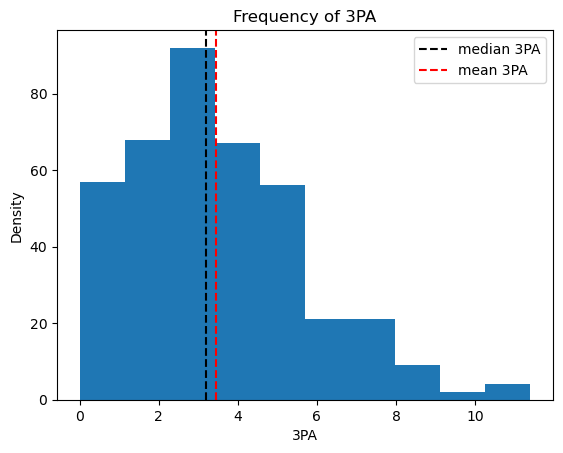

In [123]:
plt.hist(eligible['3PA'])
plt.title('Frequency of 3PA')
plt.xlabel('3PA')
plt.ylabel('Density')
plt.axvline(x = np.median(eligible['3PA']), color = 'black', linestyle = '--', label = 'median 3PA')
plt.axvline(x = np.mean(eligible['3PA']), color = 'red', linestyle = '--', label = 'mean 3PA')
plt.legend()

Our distribution is quite normal, but there is a slight right skew, so for this reason we will use median 3PA as our threshold. 

We binarize our data based on this threshold to create the below classes:

In [124]:
median_3 = np.median(eligible['3PA'])
print(f'T = 1: > {np.round(median_3, 2)} 3PA')
print(f'T = 0: <= {np.round(median_3, 2)} 3PA')

T = 1: > 3.2 3PA
T = 0: <= 3.2 3PA


In [125]:
eligible['T = 1'] = eligible['3PA'].apply(lambda x: 1 if(x > median_3) else 0) 

#### Transforming Features

For fitting our variables, we want to examine whether or not we should use nonlinearized relationships based on the scatterplots. 

Let's show the confounder scatterplots again, but just looking at the relationship between the confounder and the outcome, since that is what will determine the relationship shown in the model.

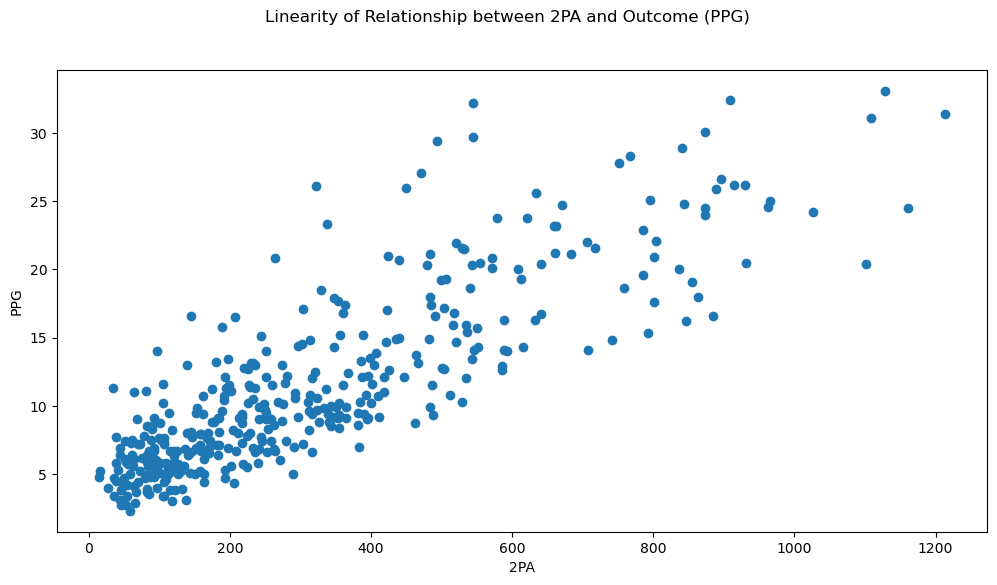

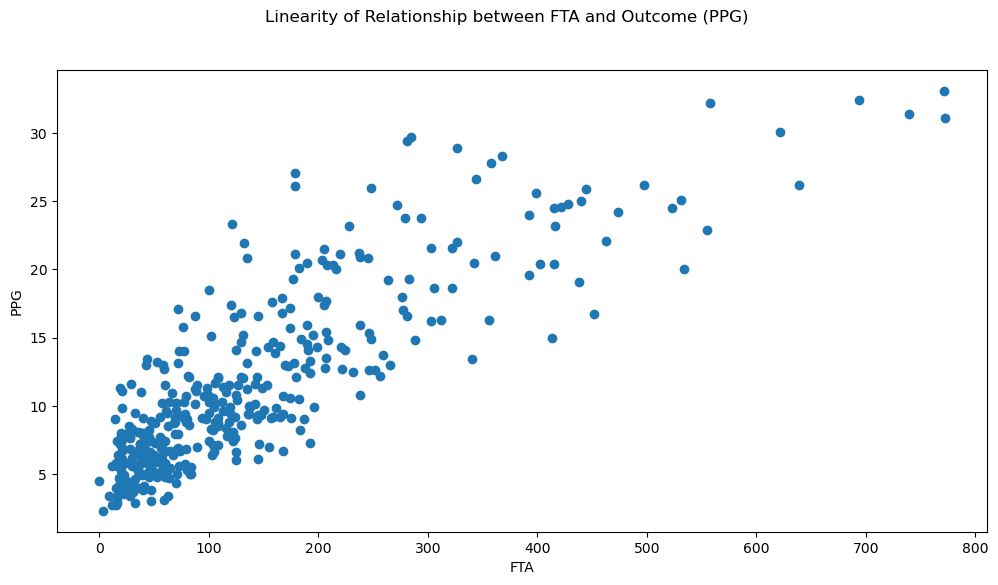

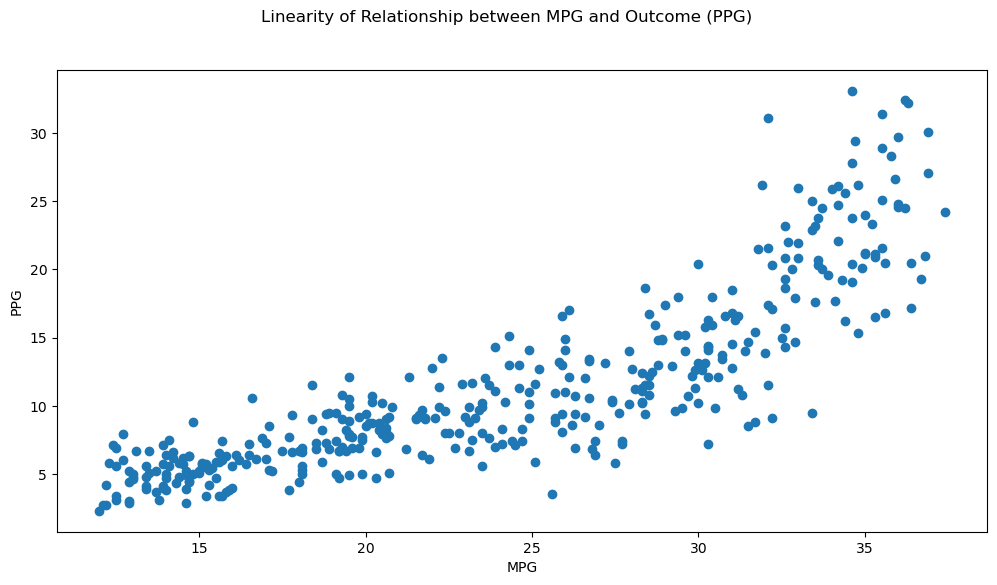

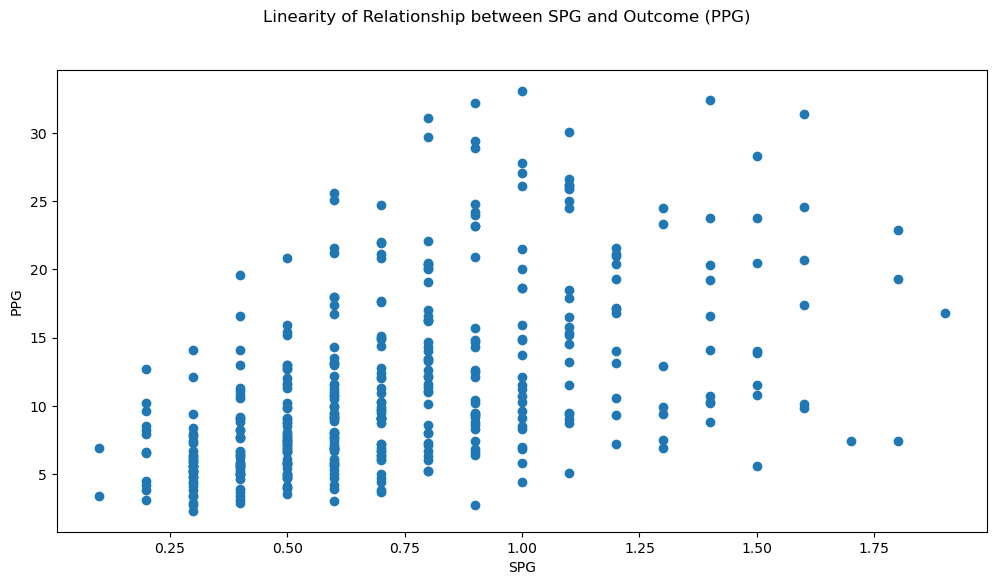

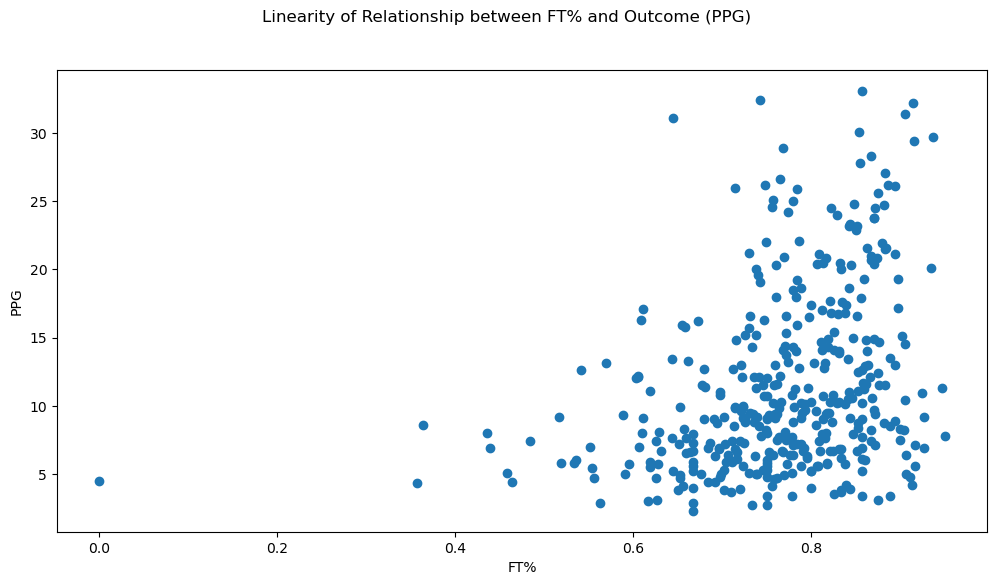

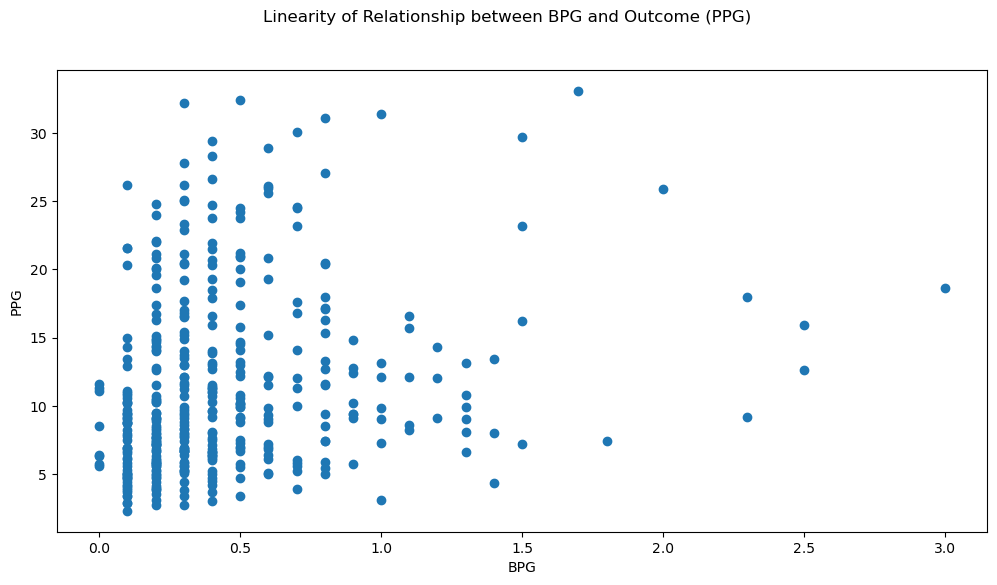

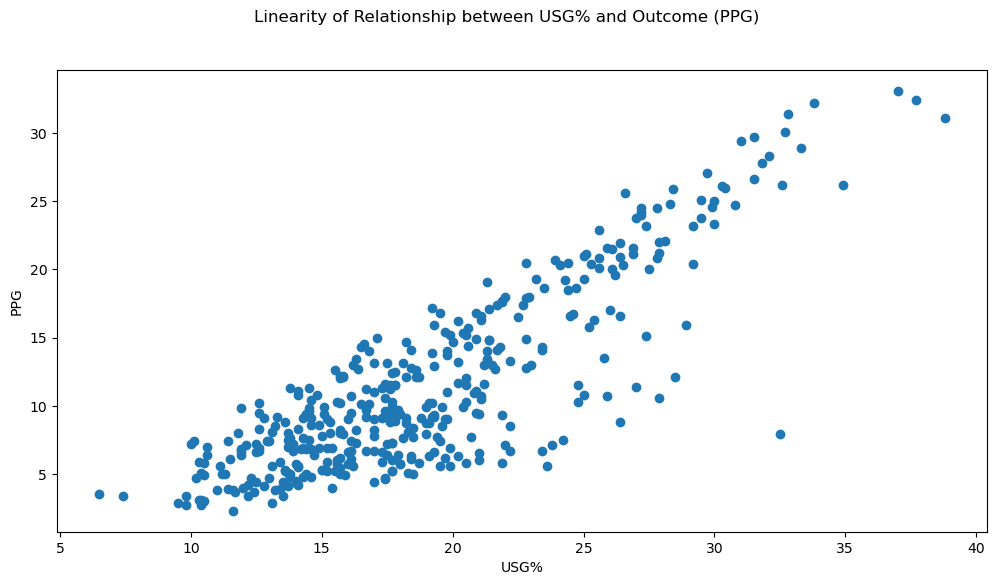

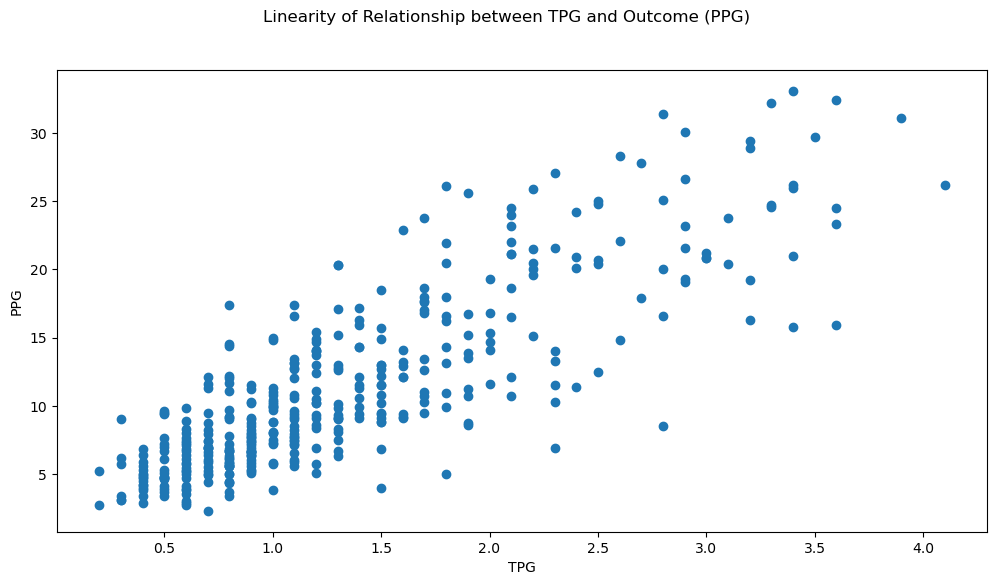

In [126]:
for confounder in final_conf:
    fig, sbp = plt.subplots(ncols=1, figsize=(12, 6))
    fig.suptitle(f'Linearity of Relationship between {confounder} and Outcome (PPG)')
    s = sbp.scatter(eligible[confounder], eligible['PPG'])
    sbp.set_xlabel(confounder)
    sbp.set_ylabel('PPG')

For the most part, we see a solid level of linear association.

For FTA, based on the shape of the data, and referencing the Tukey-Mosteller diagram, a square root transformation would help us linearize the relationship. We can do a log transformation as well, but considering we are dealing with some zero values, sqrt might work better.

For MPG, for the same reasons as above, it looks like a cubic transformation will linearize the PPG relationship. 

Note that for FT%, we see a lot of bunching up at the higher percentages, which makes sense given that free throws are easier shots and most people shoot a strong percentage. However, there is still a linear relationship. 

Let us plot what these new relationships look like for comparison:

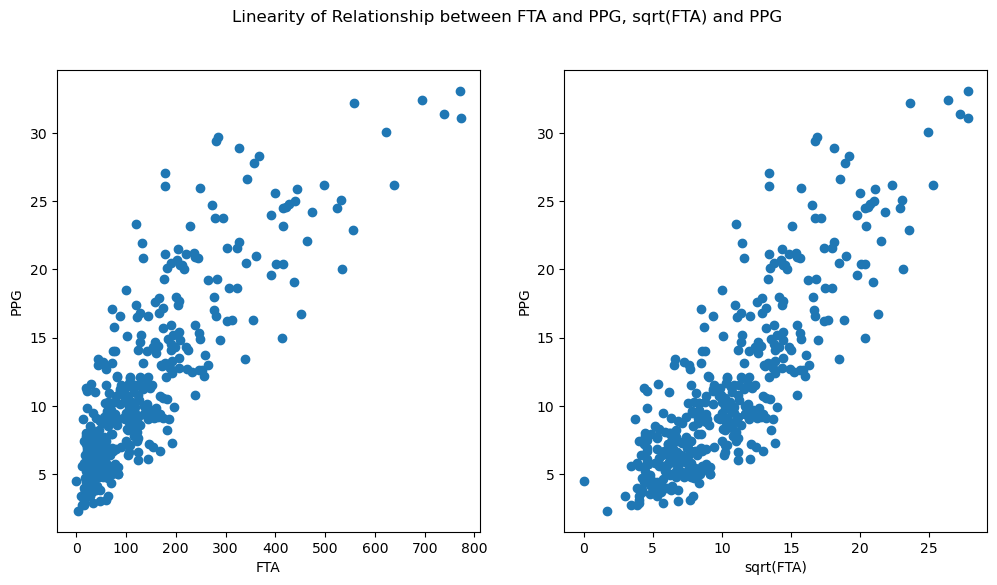

In [175]:
fig, sbp = plt.subplots(ncols=2, figsize=(12, 6))
ax0 = sbp[0] 
ax1 = sbp[1]
fig.suptitle(f'Linearity of Relationship between FTA and PPG, sqrt(FTA) and PPG')

# plotting the outcome and confounder correlation 
ax0.set_xlabel('FTA')
ax0.set_ylabel('PPG')
s = ax0.scatter(eligible['FTA'], eligible['PPG'])

# plotting the outcome and transformed confounder correlation
ax1.set_xlabel('sqrt(FTA)')
ax1.set_ylabel('PPG')
s = ax1.scatter(np.sqrt(eligible['FTA']), eligible['PPG'])

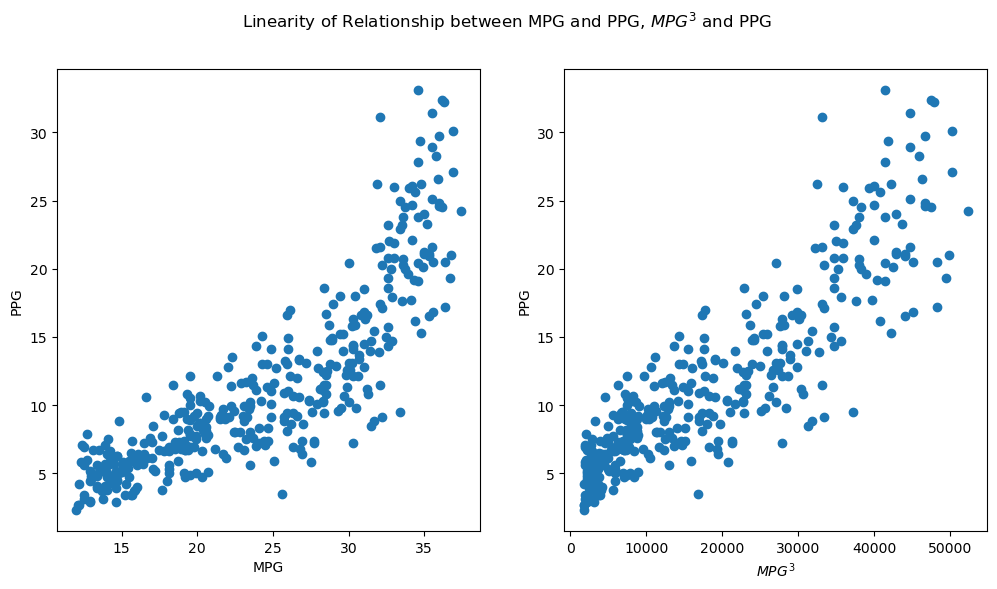

In [176]:
fig, sbp = plt.subplots(ncols=2, figsize=(12, 6))
ax0 = sbp[0] 
ax1 = sbp[1]
fig.suptitle(f'Linearity of Relationship between MPG and PPG, $MPG^3$ and PPG')

# plotting the outcome and confounder correlation 
ax0.set_xlabel('MPG')
ax0.set_ylabel('PPG')
s = ax0.scatter(eligible['MPG'], eligible['PPG'])

# plotting the outcome and transformed confounder correlation
ax1.set_xlabel('$MPG^3$')
ax1.set_ylabel('PPG')
s = ax1.scatter(eligible['MPG']**3, eligible['PPG'])

Finally, we create the new columns with our transformed features, and have our complete regression set up to run:

In [189]:
eligible['sqrt(FTA)'] = np.sqrt(eligible['FTA'])
eligible['MPG^3'] = eligible['MPG']**3

transformed_conf = list(set(final_conf) | set(['sqrt(FTA)', 'MPG^3']) - set(['FTA', 'MPG']))

final_regression = eligible[list(set(transformed_conf) | set(['T = 1', 'PPG']))]
print('Outcome: PPG')
print('Treatment: T = 1 (Higher than Median 3PA)')
print(f'Confounders: {transformed_conf}')

Outcome: PPG
Treatment: T = 1 (Higher than Median 3PA)
Confounders: ['2PA', 'sqrt(FTA)', 'FTA', 'MPG', 'MPG^3', 'SPG', 'FT%', 'BPG', 'USG%', 'TPG']


### Running the Regression

We will now use our outcome regression under two assumptions: the unconfoundedness assumption mentioned earlier, and the linearity of the relationships. 

In [190]:
X = final_regression[final_regression.columns.difference(['PPG'])]
y = final_regression[['PPG']]

In [191]:
fitted_model = sm.OLS(y, X).fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    PPG   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              3070.
Date:                Thu, 31 Oct 2024   Prob (F-statistic):                        0.00
Time:                        13:18:57   Log-Likelihood:                         -698.30
No. Observations:                 397   AIC:                                      1419.
Df Residuals:                     386   BIC:                                      1462.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
2PA            0.0002      0.001      0.253      0.801      -0.001       0.002
BPG            0.5827      0.208      2.803      0.005       0.174       0.991
FT%           -1.4234      0.683     -2.085      0.038      -2.765      -0.081
FTA            0.0150      0.002      6.428      0.000       0.010       0.020
MPG           -0.0478      0.035     -1.348      0.179      -0.117       0.022
MPG^3          0.0003   1.91e-05     14.410      0.000       0.000       0.000
SPG           -0.5069      0.277     -1.830      0.068      -1.052       0.038
T = 1          0.5196      0.191      2.718      0.007       0.144       0.895
TPG           -0.2163      0.190     -1.137      0.256      -0.590       0.158
USG%           0.4623      0.023     20.106      0.000       0.417       0.507
sqrt(FTA)     -0.1852      0.068     -2.717      0.007      -0.319      -0.051
==============================================================================
Omnibus:                       13.435   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.872
Skew:                           0.010   Prob(JB):                     5.38e-07
Kurtosis:                       4.321   Cond. No.                     2.19e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation and Limitations of Results

Based on our regression, we would expect the treatment of shooting more than the median 3 point attempts per game would lead to an increase of 0.5 PPG, on average.

That our coefficient is not particularly strong is not surprising. For one, as mentioned previously, our accounting for all confounders is suspect at best. We simply cannot account for all variables that impact our treatment and our outcome. 

We tried to address multicollinearity as much as possible, but there is still likely some present in the data, which decreases interpretability of our results. This is also a consequence of having to use background knowledge for colliders, which in and of itself requires fairly subjective assumptions

Additionally, our use of a median to binarize our data may be questionable, considering the presence of outliers within the distribution. Perhaps there is a method that would allow for us to somehow use different thresholds for different players (e.g., use a certain threshold if they are in the top 10% of 3PA). 

For any further useful data, as mentioned, if any data could exist on our unobserved confounders, that would be ideal. We could likely have used some more advanced statistics like RAPTOR, since they are pretty strong statistics and could capture some information our basic statistics simply couldn’t. We would be wary of adding anything else due to our concern for multicollinearity, however. 

Overall, we have some confidence in the causal impact of 3PA on PPG, but it is a weak impact at best. 